<a href="https://colab.research.google.com/github/Evanlerberghe-NU/MSDS451_Final/blob/main/451_Check3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
!pip install snscrape


In [26]:

BEARER_TOKEN = "AAAAAAAAAAAAAAAAAAAAAC6D3gEAAAAAH9uzZ7DOAAuPgqCvai%2FzIGASlsQ%3DMOVESx1ujncel62msMd8lEdH6EQ8eYXtbab8OWzWVrbyitxWac"   # <---- replace with your key

In [27]:

import time
from datetime import datetime, timedelta

import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

from numpy.random import multivariate_normal
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

import tweepy
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer


tickers = ["AAPL", "GOOG", "META", "CAT"]
benchmark = "^GSPC"
start_date = "1999-01-01"
end_date = "2024-12-31"

management_fee = 0.02
performance_fee_rate = 0.2
risk_free_rate = 0.01

n_simulations = 10000
n_days = 252

In [28]:


TWEET_LOOKBACK_DAYS = 3
TWEET_LIMIT_PER_TICKER = 10
RATE_LIMIT_SLEEP_SEC = 15
MAX_RETRIES = 2

BEARER_TOKEN = "AAAAAAAAAAAAAAAAAAAAAC6D3gEAAAAAH9uzZ7DOAAuPgqCvai%2FzIGASlsQ%3DMOVESx1ujncel62msMd8lEdH6EQ8eYXtbab8OWzWVrbyitxWac"  # <-- put your key here
client = tweepy.Client(bearer_token=BEARER_TOKEN, wait_on_rate_limit=False)

nltk.download("vader_lexicon", quiet=True)
sia = SentimentIntensityAnalyzer()

def scrape_tweets_api(ticker: str,
                      days_back: int = TWEET_LOOKBACK_DAYS,
                      max_tweets: int = TWEET_LIMIT_PER_TICKER,
                      max_retries: int = MAX_RETRIES):
    """
    Pull up to `max_tweets` recent English tweets mentioning the plain ticker.
    Uses no cashtag operator to avoid product limitations.
    No pagination (query limiting factor) to stay under free-tier limits.
    Retries with backoff on 429.
    """
    start_time = (datetime.utcnow() - timedelta(days=days_back)).strftime('%Y-%m-%dT00:00:00Z')
    query = f'{ticker} -is:retweet lang:en'

    attempts = 0
    while attempts <= max_retries:
        try:
            resp = client.search_recent_tweets(
                query=query,
                max_results=min(max_tweets, 10),
                start_time=start_time,
                tweet_fields=["created_at", "text"]
            )
            if resp and resp.data:
                return [t.text for t in resp.data]
            return []
        except tweepy.TooManyRequests as e:
            attempts += 1
            if attempts > max_retries:
                print(f"Rate limit hit for {ticker}; giving up after {attempts} attempts.")
                return []
            print(f"429 Too Many Requests for {ticker}. Sleeping {RATE_LIMIT_SLEEP_SEC}s (attempt {attempts}/{max_retries})...")
            time.sleep(RATE_LIMIT_SLEEP_SEC)
        except tweepy.BadRequest as e:

            print(f"Bad request for {ticker}: {e}")
            return []
        except Exception as e:

            attempts += 1
            if attempts > max_retries:
                print(f"API scrape failed for {ticker} after {attempts} attempts: {e}")
                return []
            time.sleep(2)

def sentiment_score(texts):
    if not texts:
        return 0.0
    scores = [sia.polarity_scores(t)["compound"] for t in texts]
    return float(np.mean(scores)) if scores else 0.0


sentiment_results = {}
for t in tickers:
    tweets = scrape_tweets_api(t)
    s = sentiment_score(tweets)
    sentiment_results[t] = s
print("Sentiment Index:", sentiment_results)


429 Too Many Requests for GOOG. Sleeping 15s (attempt 1/2)...
429 Too Many Requests for GOOG. Sleeping 15s (attempt 2/2)...
Rate limit hit for GOOG; giving up after 3 attempts.
429 Too Many Requests for META. Sleeping 15s (attempt 1/2)...
429 Too Many Requests for META. Sleeping 15s (attempt 2/2)...
Rate limit hit for META; giving up after 3 attempts.
429 Too Many Requests for CAT. Sleeping 15s (attempt 1/2)...
429 Too Many Requests for CAT. Sleeping 15s (attempt 2/2)...
Rate limit hit for CAT; giving up after 3 attempts.
Sentiment Index: {'AAPL': 0.55816, 'GOOG': 0.0, 'META': 0.0, 'CAT': 0.0}


In [29]:

data = yf.download(tickers + [benchmark],
                   start=start_date, end=end_date,
                   interval="1d", group_by='ticker', auto_adjust=True)

def compute_log_returns(prices: pd.Series) -> pd.Series:
    return np.log(prices / prices.shift(1)).dropna()

returns = {t: compute_log_returns(data[t]["Close"]) for t in tickers}
benchmark_returns = compute_log_returns(data[benchmark]["Close"])
returns_df = pd.DataFrame(returns)


for t in tickers:
    returns_df[f"{t}_sentiment"] = sentiment_results[t]


mean_returns = returns_df[tickers].mean().values
cov_matrix = returns_df[tickers].cov().values

simulated_returns = multivariate_normal(mean_returns, cov_matrix, (n_simulations, n_days))

def random_weights(n_assets: int) -> np.ndarray:
    w = np.random.rand(n_assets)
    return w / np.sum(w)

weights_list = np.array([random_weights(len(tickers)) for _ in range(n_simulations)])
portfolio_returns = np.einsum('ijk,ik->ij', simulated_returns, weights_list)
portfolio_cum_returns = np.exp(portfolio_returns.cumsum(axis=1))


[*********************100%***********************]  5 of 5 completed


In [30]:

hist_df = returns_df[tickers].copy()
hist_mean = hist_df.mean()
hist_cov = hist_df.cov()

sharpe_ratios, weights_store = [], []
for _ in range(10000):
    w = random_weights(len(tickers))
    port_ret = float(np.dot(hist_mean, w))
    port_vol = float(np.sqrt(np.dot(w.T, np.dot(hist_cov, w))))
    if port_vol == 0:
        sharpe = -np.inf
    else:
        sharpe = (port_ret - risk_free_rate) / port_vol
    sharpe_ratios.append(sharpe)
    weights_store.append(w)

best_weights = weights_store[int(np.argmax(sharpe_ratios))]
print("Run 42 selected for backtesting")

hist_portfolio_returns = hist_df.dot(best_weights)
hist_portfolio_cum = np.exp(hist_portfolio_returns.cumsum())

Run 42 selected for backtesting


In [31]:



def apply_fees(nav_series: pd.Series,
               management_fee: float,
               performance_fee_rate: float,
               benchmark_nav: pd.Series) -> pd.Series:

    nav = nav_series.copy()
    annual_nav = nav.resample('YE').last().squeeze()
    annual_bench = benchmark_nav.resample('YE').last().squeeze()

    gross_returns = annual_nav.pct_change().dropna()
    bench_returns = annual_bench.pct_change().dropna()


    alpha = (gross_returns - bench_returns).mean()
    perf_fee = (alpha * performance_fee_rate) if alpha is not None and alpha > 0 else 0.0

    net_returns = gross_returns - management_fee - perf_fee

    net_nav_vals = [annual_nav.iloc[0]]
    for r in net_returns:
        net_nav_vals.append(net_nav_vals[-1] * (1 + r))
    return pd.Series(net_nav_vals[1:], index=net_returns.index)

benchmark_cum = np.exp(benchmark_returns.cumsum())
fees_applied_nav = apply_fees(
    hist_portfolio_cum.to_frame(name="NAV"),
    management_fee, performance_fee_rate,
    benchmark_cum.to_frame(name="Benchmark")
)


In [32]:

aligned = pd.concat([benchmark_returns, hist_portfolio_returns], axis=1).dropna()
x = aligned.iloc[:, 0].values.reshape(-1, 1)
y = aligned.iloc[:, 1].values

lin_model = LinearRegression().fit(x, y)
beta = float(lin_model.coef_[0])
alpha = float(lin_model.intercept_)
sharpe_ratio = float((hist_portfolio_returns.mean() - risk_free_rate) / hist_portfolio_returns.std())

print(f"Alpha: {alpha:.4f}")
print(f"Beta: {beta:.4f}")
print(f"Sharpe Ratio: {sharpe_ratio:.4f}")



X_full = returns_df.copy()
y_next = X_full.shift(-1)[tickers[0]]

aligned_ml = pd.concat([X_full, y_next.rename("target")], axis=1).dropna()
X_ml = aligned_ml.drop(columns=["target"])
y_ml = aligned_ml["target"]

X_train, X_test, y_train, y_test = train_test_split(X_ml, y_ml, shuffle=False, test_size=0.2)
sentiment_model = LinearRegression().fit(X_train, y_train)
r2 = float(sentiment_model.score(X_test, y_test))
y_pred = sentiment_model.predict(X_test)
print("Sentiment-aware model R^2:", f"{r2:.4f}")

Alpha: 0.0003
Beta: 1.1587
Sharpe Ratio: -0.5483
Sentiment-aware model R^2: -0.0227


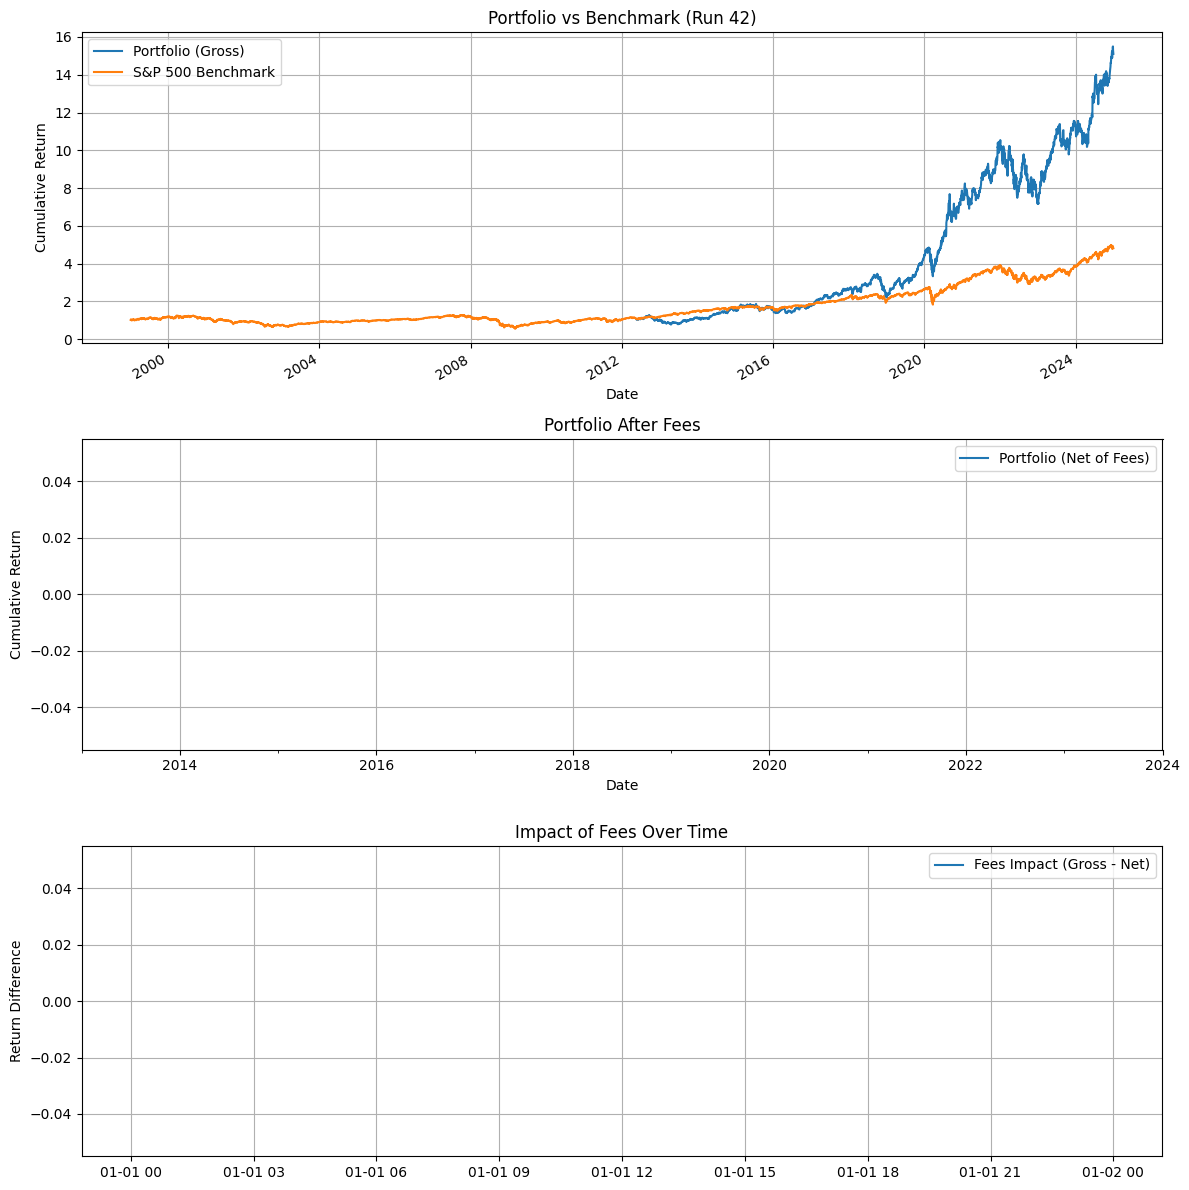

In [33]:



plt.figure(figsize=(12, 12))


plt.subplot(3, 1, 1)
hist_portfolio_cum.plot(label="Portfolio (Gross)")
benchmark_cum.plot(label="S&P 500 Benchmark")
plt.title("Portfolio vs Benchmark (Run 42)")
plt.ylabel("Cumulative Return")
plt.legend()
plt.grid()


plt.subplot(3, 1, 2)
fees_applied_nav.plot(label="Portfolio (Net of Fees)")
plt.title("Portfolio After Fees")
plt.ylabel("Cumulative Return")
plt.legend()
plt.grid()

plt.subplot(3, 1, 3)
fee_impact = hist_portfolio_cum.reindex(fees_applied_nav.index).values - fees_applied_nav.values
plt.plot(fees_applied_nav.index, fee_impact, label="Fees Impact (Gross - Net)")
plt.title("Impact of Fees Over Time")
plt.ylabel("Return Difference")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()
